---
<h1 align=center><strong><em>Brief : analyse de critiques de films</em></strong></h1>

---

### Dans ce brief, il est question de scrapper des avis et des notes sur le site d'Allociné, afin d'entraîner un modèle de machine learning nous permettant par la suite de détecter si un avis laissé par un utilisateur est positif ou négatif.

## 1. Préparation de la dataset

### a. Importer les librairies nécessaires

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from unidecode import unidecode
from googletrans import Translator

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/antancelin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### b. Importer le fichier CVS suite au scrapping

In [2]:
df = pd.read_csv('movies_final.csv',header=None)

# Renommage des colonnes
df = df.rename(columns = {0:'Commentaires', 1:'Notes'})

df.head(20)

,Commentaires,Notes
0,une bonne suite pour les aventures de sonic au...,"4,0"
1,une bonne suite pour les aventures de sonic au...,"4,0"
2,Cette suite de sonic est incroyable !Le fan qu...,"5,0"
3,une bonne suite pour les aventures de sonic au...,"4,0"
4,Cette suite de sonic est incroyable !Le fan qu...,"5,0"
5,Très bon film ont retrouve ce qui fait l’espri...,"4,5"
6,une bonne suite pour les aventures de sonic au...,"4,0"
7,Cette suite de sonic est incroyable !Le fan qu...,"5,0"
8,Très bon film ont retrouve ce qui fait l’espri...,"4,5"
9,"Super film de ouf, le fait que Knuckles soit d...","4,0"


### c. Nettoyage du dataset

Encodage de la colonne 'Notes' afin de passer de 'string' à 'float'.

In [3]:
df['Notes']= df['Notes'].str.replace(',', '.').astype(float)
df

,Commentaires,Notes
0,une bonne suite pour les aventures de sonic au...,4.0
1,une bonne suite pour les aventures de sonic au...,4.0
2,Cette suite de sonic est incroyable !Le fan qu...,5.0
3,une bonne suite pour les aventures de sonic au...,4.0
4,Cette suite de sonic est incroyable !Le fan qu...,5.0
...,...,...
5666,Tom Hanks est dans ce film ?! Et bien je n'ai ...,4.5
5667,"Spielberg à la manivelle, les frangins Cohen a...",2.5
5668,C'est un excellent film avec un Tom Hanks en p...,5.0
5669,Un film bien tourné et avec un bon jeu d'acteu...,2.5


Vérification de la présence ou non de valeurs nulles. 

In [4]:
print(df.shape)
df.isna().sum()

(5671, 2)


Commentaires    0
Notes           0
dtype: int64

Création des deux classes :
* 1 = avis positifs (quand la note > 3)
* 0 = avis négatifs (quand la note <= 3)

In [5]:
df.loc[df['Notes'] <= 3, ['Notes']] = 0
df.loc[df['Notes'] > 3, ['Notes']] = 1

df['Notes'] = df['Notes'].astype('int')
df['Notes'].value_counts()

1    3929
0    1742
Name: Notes, dtype: int64

### d. Représentation graphique

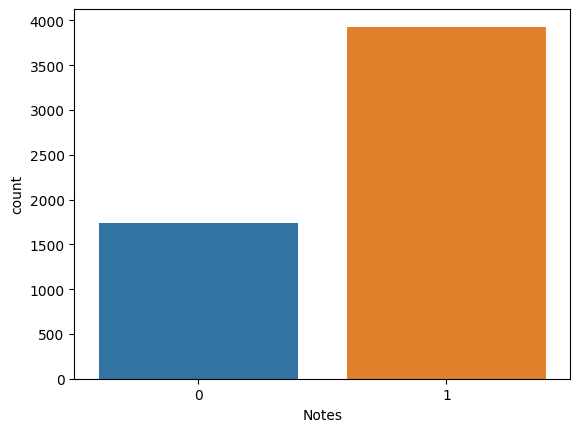

In [6]:
sns.countplot(data=df, x=df['Notes'])
plt.show()

<AxesSubplot: ylabel='Notes'>

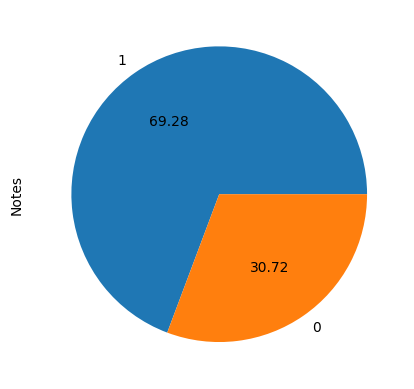

In [7]:
X = df.drop("Notes",axis = 1)
y = df["Notes"]

y.value_counts()
# Show pie plot (Approach 1)
y.value_counts().plot.pie(autopct='%.2f')

## 2. Mise en place du Machine Learning

### a. Séparation du jeu de données

In [8]:
X = df['Commentaires']
y = df['Notes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_train.value_counts())

1    3124
0    1412
Name: Notes, dtype: int64


On remarque (comme vu lors de la représentation graphique), qu'il y a beaucoup plus de commentaires positifs que négatifs, ce qui posera un problème d'équilibre. Il va être utilie de faire une Data Augmentation afin de rajouter des commentaires négatifs afin de rééquilibrer le train set.

### b. Data augmentation

In [34]:
print(f"""1ère version trainset {X_train[y_train == 0].shape[0]} avis négatifs pour {X_train[y_train == 1].shape[0]} avis positifs""")

1ère version trainset 2824 avis négatifs pour 3124 avis positifs


Pour la data augmentation, on utilise la back translation, ce qui va nous traduire un commentaire en anglais, puis le retraduire en français ce qui permet d'avoir un commentaire à la grammaire différente mais au sens inchangé.

In [10]:
def back_translate(comment):
    """Traduit en anglais puis à nouveau en français"""
    translator = Translator()
    translated = translator.translate(comment, dest = 'en').text
    translated_back = translator.translate(translated, dest = 'fr').text
    
    return translated_back

In [11]:
for text in X_train[y_train == 0]:
    comments = back_translate(text)
    X_train = pd.concat([X_train, pd.Series(comments)])
    y_train = pd.concat([y_train, pd.Series(0)])

In [12]:
print(f"""2nde version : {X_train[y_train == 0].shape[0]} avis négatifs pour {X_train[y_train == 1].shape[0]} avis positifs.""")

2nde version : 2824 avis négatifs pour 3124 avis positifs.


On voit donc que grâce à la data augmentation via back translation, on a plus ou moins rééquilibré le trainset en passant de 1124 avis négatifs à 2824, ce qui se rapproche de l'équilibre.

### c. Gestion du bruit

Cette fonction permet de supprimer tous les caractères spéciaux et la ponctuation. Elle permet aussi de transformer les majuscules en minuscules.

In [13]:
def standardize_text(data):
    data = data.str.replace(r"http\S+", "",regex=True)
    data = data.str.replace(r"http", "",regex=True)
    data = data.str.replace(r"@\S+", "",regex=True)
    data = data.str.replace(r"[0-9(),;!:?@<>.=\'\`\"\-\_\n]", " ",regex=True)
    data = data.str.replace(r"@", "at",regex=True)
    data = data.str.replace("é", "e")
    data = data.str.replace("è", "e")
    data = data.str.lower()
    return data

X_train = standardize_text(X_train)

In [15]:
X_train

718     je ne suis pas un ancien fan de sonic  mais pl...
4113    historiquement interessant  le film est realis...
670     bon  ce film a un public bien defini  les fans...
3497    un bon thriller  en deux partie  la premiere a...
5471    idee tres originale mais l essentiel de l acti...
                              ...                        
0       film qui nous raconte tout au long de l histoi...
0       plutôt spectaculaires  les scenes d action se ...
0       on se retrouve donc avec un film qui part mal ...
0       film qui nous raconte tout au long de l histoi...
0       idee tres originale mais l essentiel de l acti...
Length: 5948, dtype: object

On voit bien ici qu'il n'y a plus de caractères spéciaux, de chiffres ou encore de majuscules, le commentaire est correctment standardisé.

### d. Tokenisation
* Suppression des stopwords
* Lemmatization = mise à la racine des mots

In [14]:
print(f"Voici la liste des stopwords de la langue française : \n {stopwords.words('french')}")

Voici la liste des stopwords de la langue française : 
 ['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons',

Cette fonction permet de supprimer les stopwords et de réduire les mots à leur racine simultanément.

In [15]:
def make_corpus(df):
    lemmatizer = FrenchLefffLemmatizer()
    corpus = []
    for message in df:
        message = message.split()                                   
        message =[word for word in message if not word in set(stopwords.words('french'))]
        message = [lemmatizer.lemmatize(word) for word in message]
        message = ' '.join(message)
        corpus.append(message)
    return corpus

In [16]:
corpus = make_corpus(X_train)

In [36]:
print(f"Exemples de commentaires tokenisés : \n\n{corpus[1456]}\n\n{corpus[25]}\n\n{corpus[3569]}")

Exemples de commentaires tokenisés : 

a adorer fil an film super suite peu humour peu cascade bagarre bon cocktail bon moment recommande

excellent film voir enfant enormement references jeu mot film super rythme temps mort musique super introduction nouveau personnage tres bien decouverte differentes tribu planetes geniale espere developpe eme opus bref comedie pop corn prend serieux barre rire carey encore foi genial robotnik

simplement aime film scenario impossible comprendre deçu scenario film


### e. Vectorisation

In [18]:
tfidf = TfidfVectorizer()
X_train_vec = tfidf.fit_transform(corpus)

### f. Création des wordclouds pour les avis négatifs et positifs

In [19]:
text_negatif = ''
neg = df[df['Notes'] == 0]
for item in neg['Commentaires'].items():
    text_negatif = text_negatif + item[1]

text_positif = ''
pos = df[df['Notes'] == 1]
for item in pos['Commentaires'].items():
    text_positif = text_positif + item[1]

In [20]:
set1 = set(text_positif.split())
set2 = set(text_negatif.split())

# liste de mots communs
words_film_related = list(set1.intersection(set2))

stopwords_cloud = stopwords.words('french') + words_film_related

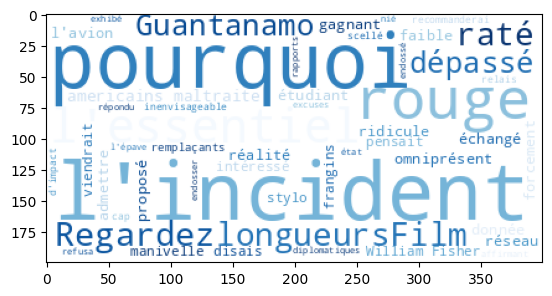

In [40]:
wordcloud_neg = WordCloud(background_color='#FFFFFF', colormap='Blues', max_words=50, min_word_length=3, stopwords=stopwords_cloud).generate(text_negatif)
plt.imshow(wordcloud_neg)

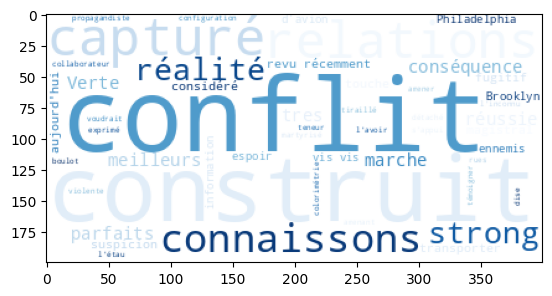

In [41]:
wordcloud_pos = WordCloud(background_color='#FFFFFF', colormap='Blues', max_words=50, min_word_length=3, stopwords=stopwords_cloud).generate(text_positif)
plt.imshow(wordcloud_pos)

## 3. Création du modèle

### a. Entraînement du modèle

In [23]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_vec, y_train)

LogisticRegression(random_state=42)

In [24]:
corpus_test = make_corpus(X_test)
X_test_vec = tfidf.transform(corpus_test)

Accuracy of LogisticRegression: 98.41409691629957 %


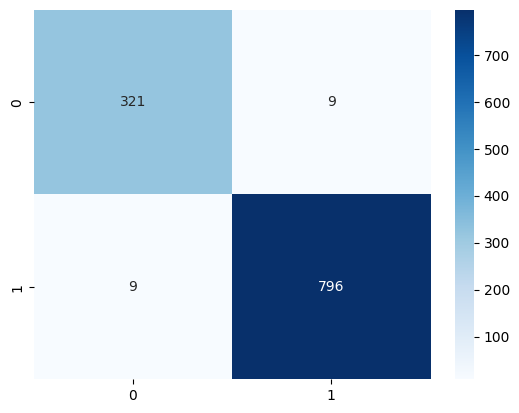

In [42]:
y_pred_clf = clf.predict(X_test_vec)
acc_clf = accuracy_score(y_pred_clf, y_test)
cm_clf = confusion_matrix(y_pred_clf, y_test)
sns.heatmap(cm_clf, annot=True, cmap='Blues', fmt='g')
print(f"Accuracy of {clf.__class__.__name__}:", acc_clf*100,"%")

On observe un score de 98,41 ce qui montre le bon fonctionnement du modèle.

### b. Fonction test avant sauvegarde et transfère à l'application Flask

In [43]:
commentaire = "très déçu, trop peu d'action"

def standardize_lemmentize_vectorize(comment: str, lemmatizer, vectorizer):

    comment = comment.replace(r"http\S+", "")
    comment = comment.replace(r"http", "")
    comment = comment.replace(r"@\S+", "")
    comment = comment.replace(r"[0-9(),!?@\'\:\.\/\^\-\`\"\_\n]", " ")
    comment = comment.replace(r"@", "at")
    comment = unidecode(comment)
    comment = comment.lower()
    comment = comment.split()
    comment = [word for word in comment if not word in set(stopwords.words('french'))]
    comment = [lemmatizer.lemmatize(word) for word in comment]
    comment = ' '.join(comment)
    comment = vectorizer.transform([comment])
    return comment

commentaire = standardize_lemmentize_vectorize(commentaire, FrenchLefffLemmatizer(), tfidf)

In [44]:
pred = clf.predict(commentaire)
pred

array([0])

On voit bien à travers le test qu'il retourne 0 soit un avis négatif.